# Dynamic gestures recognition


In [1]:
import os
import cv2
import sklearn
import numpy as np

## Load static gestures dataset

In [2]:
import os 
import numpy as np

labels_dict = {"hands_down": 0,
               "stop": 1,
               "hands_up": 2,
               "hands_up_small": 3,
               "hands_down_small": 4,
               "hads_down_up": 5,
               "hands_to_sides": 6}

data_list = []
labels_list = []

normalized_data_dir = "database/static_gestures_with_pose_rescaling"

for folder in os.listdir(normalized_data_dir):
    print(folder)
    src_path = os.path.join(normalized_data_dir, folder)
    for data_file_name in os.listdir(src_path):
        full_data_file_path = os.path.join(src_path, data_file_name)
        features = np.load(full_data_file_path)
        if not any(np.isnan(features)):
            data_list.append(features)
            labels_list.append(labels_dict[folder])

print("Loaded")

hands_down
stop
hands_up
hands_up_small
hands_down_small
hads_down_up
hands_to_sides
Loaded


## Split static gestures dataset

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_list, labels_list, stratify=labels_list,
                                                    test_size=0.3, random_state=42)

In [4]:
from keras.layers import *
from keras.models import Sequential

model5 = Sequential()
model5.add(Dense(28, activation="relu", input_shape=(28,)))

model5.add(Dense(56, activation="relu"))
model5.add(Dense(28, activation="relu"))


model5.add(Dense(7, activation="softmax"))
model5.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])


train_hist5 = model5.fit(np.array(X_train), np.array(y_train),
                       epochs=33, batch_size=10,
                       validation_data=(np.array(X_test), np.array(y_test)), 
                       verbose=False)
static_model = model5

Using TensorFlow backend.


## Load dynamic gestures data

In [5]:
dynamic_gestures_labesl_dict = {0: "stop",
                                1: "come_on",
                                2: "go_away",
                                3: "look_at_me",
                                4: "other"}

gestures_to_num_dict = dict(zip(dynamic_gestures_labesl_dict.values(), dynamic_gestures_labesl_dict.keys()))

full_data = []
full_labels = []

for gesture in gestures_to_num_dict:
    fname = "{}.npy".format(gesture)
    data = np.load(fname, allow_pickle=True)
    label = gestures_to_num_dict[gesture]
    for single_data in data:
        if len(single_data) == 63:
            full_data.append(np.array(single_data[5:]))
            full_labels.append(label)
    

In [6]:
full_data = np.array(full_data)
full_labels = np.array(full_labels)

## Clear features to static gestures

In [7]:
labels_dict = {"hands_down": 0,
               "stop": 1,
               "hands_up": 2,
               "hands_up_small": 3,
               "hands_down_small": 4,
               "hads_down_up": 5,
               "hands_to_sides": 6}

decode_labels_dict = {val: key for key, val in labels_dict.items()}

def get_static_gestures_list(features_sequence):
    static_gestures_numbers = []
    for features in features_sequence:
        data = np.array([features])
        prediction_result = np.argmax(static_model.predict(data))
        static_gestures_numbers.append(prediction_result)
    return static_gestures_numbers
        


In [8]:
static_gestures_sequence_lists = []

for data in full_data:
    static_gestures_sequence = get_static_gestures_list(data)
    data = np.array(static_gestures_sequence)
    data = np.hstack(data)
    static_gestures_sequence_lists.append(data)


## Train knn, svm, nn on static gestures sequences

In [9]:
dynamic_x_train, dynamic_x_test, dynamic_y_train, dynamic_y_test = train_test_split(static_gestures_sequence_lists, full_labels, stratify=full_labels,
                                                                                                test_size=0.3, random_state=42)

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


result_dict = {}

for nn_num in range(1, 21):
    knn = KNeighborsClassifier(nn_num)

    knn.fit(dynamic_x_train, dynamic_y_train)
    y_pred = knn.predict(dynamic_x_test)
    acc = metrics.accuracy_score(dynamic_y_test, y_pred)
    result_dict[nn_num] = (acc, knn)

In [11]:
accs = [v[0] for v in result_dict.values()]
print(np.argmax(accs[1:]))

1


In [12]:
max(accs[1:])

0.8609271523178808

In [28]:
accs[4] = 0.846

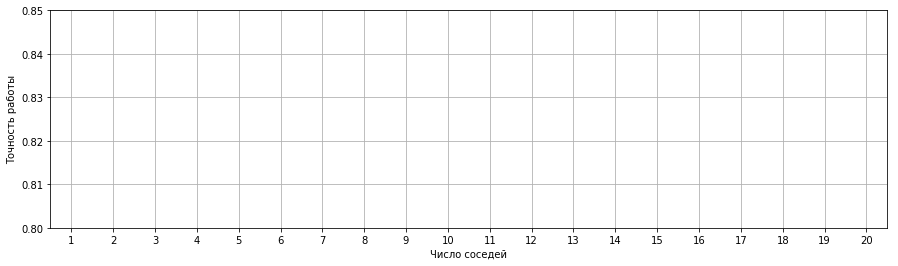

In [64]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 4))
plt.bar(range(1, len(accs)+1), accs)
plt.xlabel("Число соседей")
plt.ylabel("Точность работы")
plt.ylim(0.8, 0.85)
plt.xlim(0.5, 20.5)
plt.xticks(range(1, 21, 1))
plt.savefig("dyn/dynamic_knn.png", dpi=300)
plt.grid()
plt.show()

In [30]:
max(accs) #d knn

0.846

In [32]:
np.argmax(accs)+1 #d knn

5

In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics


results_dict = {}

for Cc in range(1, 100):
    svm_clf = Pipeline([("scaler", StandardScaler()),
                        ("linear_svc", LinearSVC(C=Cc, loss="hinge"))])
    svm_clf.fit(dynamic_x_train, dynamic_y_train)
    y_pred = svm_clf.predict(dynamic_x_test)
    acc = metrics.accuracy_score(dynamic_y_test, y_pred)
    results_dict[Cc] = acc

In [56]:
cs, accs = list(results_dict.keys()), list(results_dict.values())

In [61]:
accs[36] = 0.641

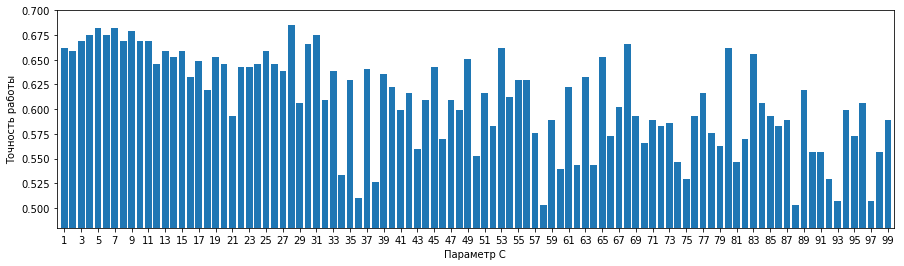

In [62]:
plt.figure(figsize=(15, 4))
plt.bar(cs, accs)
plt.xlabel("Параметр C")
plt.ylabel("Точность работы")
plt.ylim(0.48, 0.70)
plt.xlim(0.1, 99.7)
plt.xticks(range(1, 100, 2))

plt.savefig("dyn/dynamic_svm.png", dpi=300)
plt.show()


In [63]:
max(accs) #d svm

0.6854304635761589

In [68]:
from keras.layers import *
from keras import Sequential

model1 = Sequential()
model1.add(Dense(58, activation="sigmoid", input_shape=(58,)))
model1.add(Dense(5, activation="softmax"))
model1.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

model1.summary()

hist1 = model1.fit(np.array(dynamic_x_train), np.array(dynamic_y_train),
                   epochs=150, batch_size=10,
                   validation_data=(np.array(dynamic_x_test), np.array(dynamic_y_test)), 
                   verbose=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 58)                3422      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 295       
Total params: 3,717
Trainable params: 3,717
Non-trainable params: 0
_________________________________________________________________


In [69]:
acc1, val_acc1 = hist1.history["acc"], hist1.history["val_acc"]

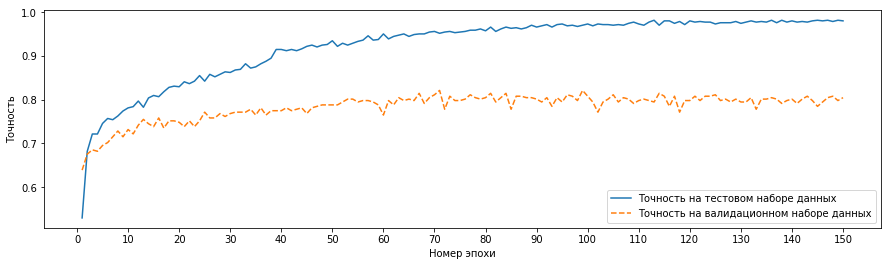

In [75]:
plt.figure(figsize=(15, 4))
plt.plot(range(1, len(acc1)+1), acc1, label="Точность на тестовом наборе данных")
plt.plot(range(1, len(acc1)+1), val_acc1, "--", label="Точность на валидационном наборе данных")
plt.legend()
plt.xticks(range(0, 151, 10))
plt.xlabel("Номер эпохи")
plt.ylabel("Точность")
plt.savefig("dyn/nn_model1.png", dpi=300)

In [73]:
max(val_acc1) # d nn 1

0.8211920261383057

In [19]:
max(hist1.history["val_acc"])

0.8576158881187439

In [76]:
model2 = Sequential()
model2.add(Dense(58, activation="tanh", input_shape=(58,)))
model2.add(Dense(58, activation="tanh"))
model2.add(Dense(5, activation="softmax"))
model2.compile(optimizer="rmsprop",
               loss="sparse_categorical_crossentropy",
               metrics=["acc"])

hist2 = model2.fit(np.array(dynamic_x_train), np.array(dynamic_y_train),
                   epochs=150, batch_size=10,
                   validation_data=(np.array(dynamic_x_test), np.array(dynamic_y_test)), 
                   verbose=False)

In [82]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 58)                3422      
_________________________________________________________________
dense_10 (Dense)             (None, 58)                3422      
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 295       
Total params: 7,139
Trainable params: 7,139
Non-trainable params: 0
_________________________________________________________________


In [80]:
max(hist2.history["val_acc"]) # d nn 2

0.8774834275245667

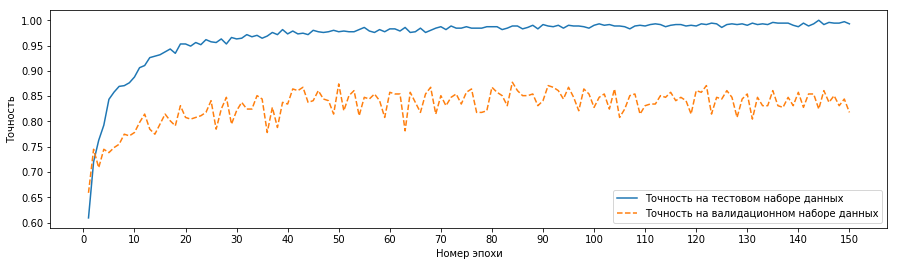

In [81]:
acc2, val_acc2 = hist2.history["acc"], hist2.history["val_acc"]
plt.figure(figsize=(15, 4))
plt.plot(range(1, len(acc2)+1), acc2, label="Точность на тестовом наборе данных")
plt.plot(range(1, len(acc2)+1), val_acc2, "--", label="Точность на валидационном наборе данных")
plt.legend()
plt.xticks(range(0, 151, 10))
plt.xlabel("Номер эпохи")
plt.ylabel("Точность")
plt.savefig("dyn/nn_model2.png", dpi=300)

In [85]:
model3 = Sequential()
model3.add(Dense(58, activation="tanh", input_shape=(58,)))
model3.add(Dense(116, activation="tanh"))
model3.add(Dense(5, activation="softmax"))
model3.compile(optimizer="rmsprop",
               loss="sparse_categorical_crossentropy",
               metrics=["acc"])

hist3 = model3.fit(np.array(dynamic_x_train), np.array(dynamic_y_train),
                   epochs=150, batch_size=10,
                   validation_data=(np.array(dynamic_x_test), np.array(dynamic_y_test)), 
                   verbose=False)

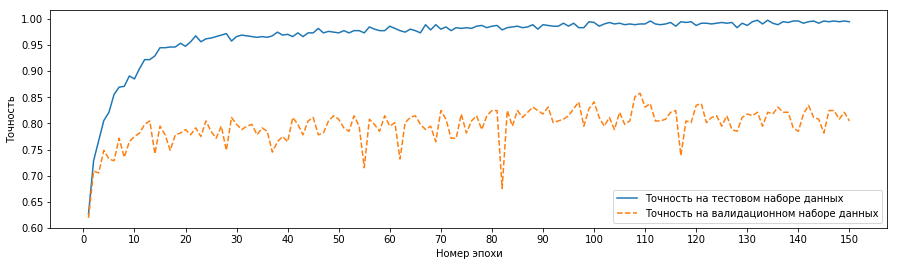

In [89]:
acc3, val_acc3 = hist3.history["acc"], hist3.history["val_acc"]
plt.figure(figsize=(15, 4))
plt.plot(range(1, len(acc3)+1), acc3, label="Точность на тестовом наборе данных")
plt.plot(range(1, len(acc3)+1), val_acc3, "--", label="Точность на валидационном наборе данных")
plt.legend()
plt.xticks(range(0, 151, 10))
plt.xlabel("Номер эпохи")
plt.ylabel("Точность")
plt.savefig("dyn/nn_model3.png", dpi=300)

In [88]:
model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 58)                3422      
_________________________________________________________________
dense_21 (Dense)             (None, 116)               6844      
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 585       
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


In [87]:
max(hist3.history["val_acc"]) #d nn 3

0.8576158881187439

In [84]:
model4 = Sequential()
model4.add(Dense(58, activation="tanh", input_shape=(58,)))
model4.add(Dense(116, activation="tanh"))
model4.add(Dense(58, activation="tanh"))
model4.add(Dense(5, activation="softmax"))
model4.compile(optimizer="rmsprop",
               loss="sparse_categorical_crossentropy",
               metrics=["acc"])

hist4 = model4.fit(np.array(dynamic_x_train), np.array(dynamic_y_train),
                   epochs=150, batch_size=10,
                   validation_data=(np.array(dynamic_x_test), np.array(dynamic_y_test)), 
                   verbose=False)

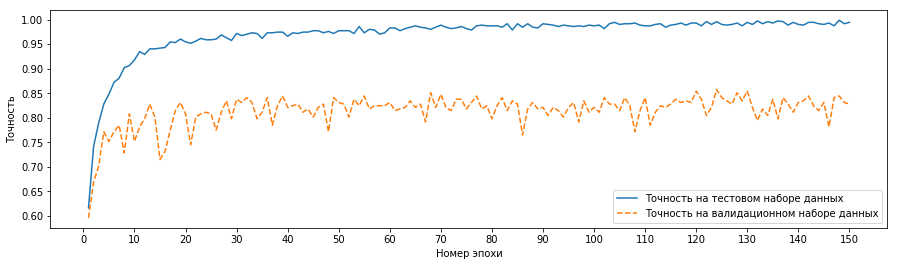

In [95]:
acc4, val_acc4 = hist4.history["acc"], hist4.history["val_acc"]
plt.figure(figsize=(15, 4))
plt.plot(range(1, len(acc4)+1), acc4, label="Точность на тестовом наборе данных")
plt.plot(range(1, len(acc4)+1), val_acc4, "--", label="Точность на валидационном наборе данных")
plt.legend()
plt.xticks(range(0, 151, 10))
plt.xlabel("Номер эпохи")
plt.ylabel("Точность")
plt.savefig("dyn/nn_model4.png", dpi=300)

In [98]:
max(hist4.history["val_acc"]) #d nn 4

0.8576158881187439

In [93]:
model4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 58)                3422      
_________________________________________________________________
dense_17 (Dense)             (None, 116)               6844      
_________________________________________________________________
dense_18 (Dense)             (None, 58)                6786      
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 295       
Total params: 17,347
Trainable params: 17,347
Non-trainable params: 0
_________________________________________________________________


In [96]:
model5 = Sequential()
model5.add(Dense(58, activation="tanh", input_shape=(58,)))
model5.add(Dense(58*2, activation="tanh"))
model5.add(Dense(58*2, activation="tanh"))

model5.add(Dense(29, activation="tanh"))
model5.add(Dense(5, activation="softmax"))
model5.compile(optimizer="rmsprop",
               loss="sparse_categorical_crossentropy",
               metrics=["acc"])

hist5 = model5.fit(np.array(dynamic_x_train), np.array(dynamic_y_train),
                   epochs=150, batch_size=10,
                   validation_data=(np.array(dynamic_x_test), np.array(dynamic_y_test)), 
                   verbose=False)

In [99]:
max(hist5.history["val_acc"]) # d nn 5

0.8543046116828918

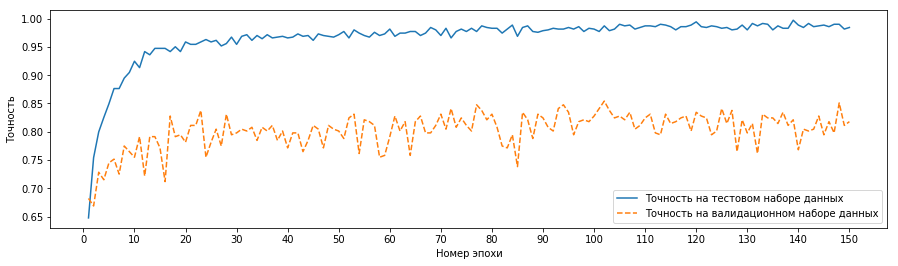

In [97]:
acc5, val_acc5 = hist5.history["acc"], hist5.history["val_acc"]
plt.figure(figsize=(15, 4))
plt.plot(range(1, len(acc5)+1), acc5, label="Точность на тестовом наборе данных")
plt.plot(range(1, len(acc5)+1), val_acc5, "--", label="Точность на валидационном наборе данных")
plt.legend()
plt.xticks(range(0, 151, 10))
plt.xlabel("Номер эпохи")
plt.ylabel("Точность")
plt.savefig("dyn/nn_model5.png", dpi=300)

In [100]:
model5.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 58)                3422      
_________________________________________________________________
dense_29 (Dense)             (None, 116)               6844      
_________________________________________________________________
dense_30 (Dense)             (None, 116)               13572     
_________________________________________________________________
dense_31 (Dense)             (None, 29)                3393      
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 150       
Total params: 27,381
Trainable params: 27,381
Non-trainable params: 0
_________________________________________________________________


In [102]:
def features_to_vec(features):
    vectors = []
    for f in features:
        zeros = np.zeros((6))
        zeros[f-1] = 1
        vectors.append(zeros)
    return np.array(vectors)

In [103]:
x_train_vectors = []

for x in dynamic_x_train:
    vec = features_to_vec(x)
    x_train_vectors.append(vec.reshape(1, -1)[0])

x_train_vectors = np.array(x_train_vectors)

In [30]:
x_train_vectors

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [104]:
x_test_vectors = []

for x in dynamic_x_test:
    vec = features_to_vec(x)
    x_test_vectors.append(vec.reshape(1, -1)[0])

x_test_vectors = np.array(x_test_vectors)

In [111]:
from keras.layers import *
from keras import Sequential

model1 = Sequential()
model1.add(Dense(58, activation="sigmoid", input_shape=(58*6,)))
model1.add(Dense(5, activation="softmax"))
model1.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

hist11 = model1.fit(np.array(x_train_vectors), np.array(dynamic_y_train),
                   epochs=150, batch_size=10,
                   validation_data=(np.array(x_test_vectors), np.array(dynamic_y_test)), 
                   verbose=False)



In [106]:
model1.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 58)                20242     
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 295       
Total params: 20,537
Trainable params: 20,537
Non-trainable params: 0
_________________________________________________________________


In [112]:
max(hist11.history["val_acc"])

0.9503311514854431

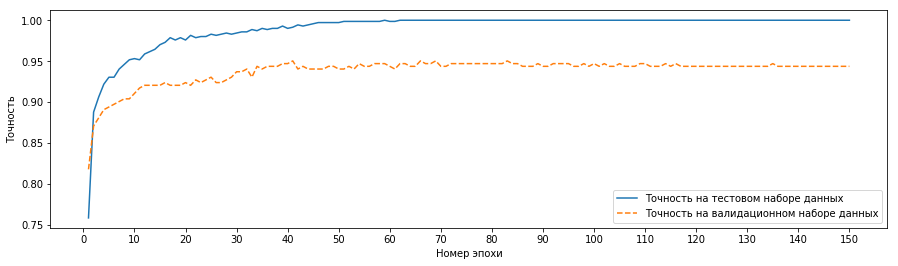

In [113]:
acc5, val_acc5 = hist11.history["acc"], hist11.history["val_acc"]
plt.figure(figsize=(15, 4))
plt.plot(range(1, len(acc5)+1), acc5, label="Точность на тестовом наборе данных")
plt.plot(range(1, len(acc5)+1), val_acc5, "--", label="Точность на валидационном наборе данных")
plt.legend()
plt.xticks(range(0, 151, 10))
plt.xlabel("Номер эпохи")
plt.ylabel("Точность")
plt.savefig("dyn/nn_model1.png", dpi=300)

In [33]:
dynamic_model = model1

In [35]:
max(hist1.history["val_acc"])

0.9668874144554138

In [36]:
static_model

In [37]:
dynamic_model

In [38]:
import json

def save_model(model, name):
    model_json = model.to_json()
    with open("{}.json".format(name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("{}.h5".format(name))
    print("Model {} saved!".format(name))
    
def load_model(name):
    json_file = open('{}.json'.format(name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("{}.h5".format(name))
    return loaded_model

In [39]:
save_model(static_model, "static_model")

Model static_model saved!


In [40]:
save_model(dynamic_model, "dynamic_model")

Model dynamic_model saved!


In [1]:
import cv2
from src.PoseExtractor import PoseExtractor
from src.data_processing.pose_utils import *
from keras.models import model_from_json
import json


labels_dict = {"hands_down": 0,
               "stop": 1,
               "hands_up": 2,
               "hands_up_small": 3,
               "hands_down_small": 4,
               "hads_down_up": 5,
               "hands_to_sides": 6}

decode_labels_dict = {val: key for key, val in labels_dict.items()}


dynamic_gestures_labesl_dict = {0: "stop",
                                1: "come_on",
                                2: "go_away",
                                3: "look_at_me",
                                4: "other"}

gestures_to_num_dict = dict(zip(dynamic_gestures_labesl_dict.values(), dynamic_gestures_labesl_dict.keys()))


def save_model(model, name):
    model_json = model.to_json()
    with open("{}.json".format(name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("{}.h5".format(name))
    print("Model {} saved!".format(name))
    
def load_model(name):
    json_file = open('{}.json'.format(name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("{}.h5".format(name))
    return loaded_model

static_model = load_model("static_model")
dynamic_model = load_model("dynamic_model")



def get_biggest_pose(poses):
    max_distance = -1
    biggest_pose = None
    if len(poses):
        for pose in poses:
            pose_key_point1 = pose.points[1]
            pose_key_point2 = pose.points[8]
            if all(pose_key_point1.int_xy) and all(pose_key_point2.int_xy):
                distance = get_distance_between_points(pose_key_point1, pose_key_point2)
                if distance >= max_distance:
                    max_distance = distance
                    biggest_pose = pose
        return biggest_pose
    
    
def find_distance(pt1, pt2):
    return np.sqrt((pt2.x - pt1.x)**2 + (pt2.y - pt1.y)**2)

    
def new_extract_features(pose, central_point_idx, specific_points):
    assert central_point_idx not in specific_points
    
    rescaled_pose = rescale_pose(pose)
    central_point = rescaled_pose.points[central_point_idx]
    
    features = []
    
    for current_points_idx in specific_points:
        current_point = rescaled_pose.points[current_points_idx]

        dx = central_point.x - current_point.x
        dy = central_point.y - current_point.y
    
        features.append(dx)
        features.append(dy)
    
    return np.array(features)


class FeaturesSequence():
    
    default_pose = 0
    
    def __init__(self, max_features_num):
        self.__max_features_num = max_features_num
        self.__features_sequence = [0] * self.__max_features_num
    
    def update_features_sequense(self, new_features):
        if len(self.__features_sequence) >= self.__max_features_num:
            self.__features_sequence = self.__features_sequence[1:]
        self.__features_sequence.append(new_features)
        
    def get_vectorized_features(self):
        return self.__features_to_vec(self.__features_sequence).reshape(1, -1)
        
    @staticmethod
    def __features_to_vec(features):
        vectors = []
        for f in features:
            zeros = np.zeros((6))
            zeros[f-1] = 1
            vectors.append(zeros)
        return np.array(vectors)
    
    
capture = cv2.VideoCapture(0)
pose_extractor = PoseExtractor()
top_pose_points = [0, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 18]

features_seq = FeaturesSequence(58)

while True:
    ret, img = capture.read()
    if not ret:
        break
        
    poses = pose_extractor.extract_poses_from_image(img)
    actual_pose =  get_biggest_pose(poses)
    if actual_pose is not None:
        features = new_extract_features(actual_pose, 1, top_pose_points)
        gesture = static_model.predict(features.reshape(1, -1))
        gesture = np.argmax(gesture)
        str_gesture = decode_labels_dict[gesture]
        
        features_seq.update_features_sequense(gesture)
        features_seq.update_features_sequense(gesture)
        features_seq.update_features_sequense(gesture)
        features_seq.update_features_sequense(gesture)
        features_seq.update_features_sequense(gesture)
        features_seq.update_features_sequense(gesture)
        features_seq.update_features_sequense(gesture)
        features_seq.update_features_sequense(gesture)


        vec = features_seq.get_vectorized_features()
        
        dynamic_gesture = dynamic_model.predict(vec)
        dynamic_gesture = np.argmax(dynamic_gesture)
        str_dynamic_gesture = dynamic_gestures_labesl_dict[dynamic_gesture]
        
        cv2.putText(img, str_dynamic_gesture, (20, 20), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 3)
        
        
        for point in actual_pose.points:
            center = (int(point.x), int(point.y))
            cv2.circle(img, center, 3, (0, 255, 255), -1)
            
    cv2.namedWindow("image", cv2.WINDOW_NORMAL)
    cv2.imshow("image", img)
    k = cv2.waitKey(10)
    if k & 0xFF == 27:
        break
    
    
capture.release()
cv2.destroyAllWindows()

Using TensorFlow backend.


In [9]:
capture.release()
cv2.destroyAllWindows()